<a href="https://colab.research.google.com/github/jialun1221/scRNA-seq/blob/main/DEep_Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install scanpy
import numpy as np
import pandas as pd
import scanpy as sc
import sys
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import importlib
required_libraries = ['torch', 'torchvision', 'PIL', 'matplotlib',
                      'numpy', 'pandas']
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#m1
adata = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_PC_all_genes_qc.h5ad")
adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

X = adata.obsm["X_pca"].X
y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

In [ ]:
#m2
adata = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_PC_HVGs_qc.h5ad")
adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

X = adata.obsm["X_pca"].X
y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

In [ ]:
#m3
adata = sc.read_h5ad("drive/MyDrive/scRNA ML classifier/data_objects_May_2022/DAN_no_PC_HVGs_qc.h5ad")
adata.obs = adata.obs.reset_index() #reset the index for X, so the column number starts from 0

X = adata.X
y = adata.obs['disease__ontology_label'].replace({"normal": "0", "Parkinson disease": "1"})

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import scanpy as sc

from torch.utils.data import TensorDataset

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# seed = 4321
# np.random.seed(seed) # Set the random seed of numpy for the data split.
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

In [ ]:
import random

I got everthing :)



In [ ]:
#the real train and test dataset
# train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
# val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
# test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

####Set up the model.

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self):
      super(NeuralNet, self).__init__()
      self.n = X_train.shape[1] #number of rows

      self.fc1 = nn.Linear(self.n, int(self.n/2))
      self.fc2 = nn.Linear(int(self.n/2), int(self.n/4))
      #self.fc3 = nn.Linear(int(len(X_train)/4),int(len(X_train)/8))
      self.output = nn.Linear(int(self.n/4), 2)

      # this are defining the layers and the hyper paramters that means the
      # conditions to compare

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      #x = F.relu(self.fc3(x))
      out = self.output(x)   # the RelU is non linearity that removes all negative values and shouldn't be used right before softmax
      return out

    def print(self):
        return self.fc1

# A = NeuralNet()
# A.print()
      # here we are telling the model how to pass the information from on layer to the next
      #in pytorch we do not explain the graph traveral method as this computational graph is automatically defined

In [ ]:
import copy

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X, y, test_size=0.2, random_state=0) #initial stabilized split

seed_list = []

for m in range (10):
  X_test = copy.deepcopy(X_test_global)
  y_test = copy.deepcopy(y_test_global)

  if len(seed_list) < 10:
    seed = random.randint(0, 9999)
    seed_list.append(seed)
    print("seed: ", seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])
  else:
    print("seed = ", seed)
    print(seed_list[m])
    X_train, X_val, y_train, y_val = train_test_split(X_train_global, y_train_global, test_size=0.25, random_state= seed_list[m])
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

#Take some data from test set for validation
#Get the validation dataset splitted
# X_val = X_test.head(499)
# X_test = X_test.tail(1000)
# y_val = y_test.head(499)
# y_test = y_test.tail(1000)
# print(X_val.shape, X_test.shape, y_val.shape, y_test.shape)

  # Type conversion
  X_val = X_val.astype(np.float64)
  y_val = y_val.astype(np.float64)
  # X_val = X_val.to_numpy()
  # y_val = y_val.to_numpy()

  #Note: SoftMax requires a 2x1 matrix for the label. We turn the above `y_val`, `y_train` and `y_test` numpy array into a matrix.
  y_val = np.stack([y_val, 1-y_val])
  y_val = y_val.transpose()
  #print(y_val)

  y_train = y_train.astype(np.float64)
  y_train = np.stack([y_train, 1-y_train])
  y_train = y_train.transpose()
  #print(y_train)

  y_test = y_test.astype(np.float64)
  y_test = np.stack([y_test, 1-y_test])
  y_test = y_test.transpose()
  #print(y_test)

  # X_train = X_train.to_numpy()
  # X_test = X_test.to_numpy()

  #the real train and test dataset
  print(X_train.shape, y_train.shape)
  train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
  val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
  test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
# Model definition - we definited above here we initiate a model
neural_net = NeuralNet()
neural_net = neural_net.to(device) #We create an instance of NeuralNetwork, and move it to the device, and print its structure.

# Evaluation mode activation
neural_net = neural_net.eval()

# Select the first 5 data points the name of the model is data
data, target = test_dataset[0:5]

data = data.to(device)
target = target.to(device)

# Forward propagation of the data through the model
output = neural_net(data)   # equivalent to neural_net.forward(data)
print("output",output)
# Convert the logits into probabilities with softmax function
output_proba = F.softmax(output,dim=1)  # the dimension is to normalize over the outcome, over rows or columns 0 will be incorrect and sum over columns

# Printing the probability
print(output_proba)

In [ ]:
_, prediction = torch.max(output_proba, dim=1)

print('Model prediction')
print(prediction)

# Printing the real labels
print("Actual data")
print(target)

Model prediction
tensor([1, 1, 1, 1, 1])
Actual data
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]])


In [ ]:
def loss_function(prediction, target):
    loss = F.cross_entropy(prediction, target)
    return loss

Using [Adam Optimizer](https://pythonguides.com/adam-optimizer-pytorch/)

In [ ]:
optimizer = optim.Adam(neural_net.parameters(), lr=0.001)

In [ ]:
train_batch_size = 32  # number of data in a training batch.
eval_batch_size = 32   # number of data in an batch.

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False)

In [ ]:
def train(epoch, model, train_loader, optimizer, device):

    # activate the training mode
    model.train()

    torch.set_grad_enabled(True)

    total_loss = 0
    correct = 0

    # iteration over the mini-batches
    for batch_idx, (data, target) in enumerate(train_loader):

        # transfer the data on the chosen device
        data, target = data.to(device), target.to(device)
        target=target.float()

        # reinitialize the gradients to zero
        optimizer.zero_grad()

        # forward propagation on the data
        prediction = model(data)

        # compute the loss function w.r.t. the targets
        loss = loss_function(prediction, target)

        # execute the backpropagation
        loss.backward()

        # execute an optimization step
        optimizer.step()

        # accumulate the loss
        total_loss += loss.item()*len(data)
        # we multiply by the length of the data incase the last minibatch is smaller we are 'denormalizing' so that a small batch isn't overweighted

        # compute the number of correct predictions
        _, pred_classes = torch.max(prediction, dim=1)
        _, target_classes = torch.max(target, dim=1)

        #print(pred_classes)
        #print(type(pred_classes))
        #print(pred_classes.shape)

        #print(prediction.shape)
        correct += int(pred_classes.eq(target_classes).sum().item())
        # print('pred', prediction)
        # print('target', target)
        # print('correct', correct)
        #print(prediction.shape)

    # compute the average loss per epoch
    mean_loss = total_loss/len(train_loader.dataset)

    # compute the accuracy
    acc = correct / len(train_loader.dataset)

    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))

    # return the average loss and the accuracy
    return mean_loss, acc

In [ ]:
# Evaluation Procedure
def evaluate(model, eval_loader, device):

    # activate the evaluation mode
    model.eval()

    total_loss = 0
    correct = 0

    with torch.no_grad():
    # we don't need to compute the gradient graph it using too much compuatation
        # iterate over the batches
        for batch_idx, (data, target) in enumerate(eval_loader):

            # transfer the data on the chosen device
            data, target = data.to(device), target.to(device)
            target=target.float()

            # forward propagation on the data
            prediction = model(data)

            # compute the loss function w.r.t. the targets
            loss = loss_function(prediction, target)

            # accumulate the loss
            total_loss += loss.item()*len(data)

            # compute the number of correct predictions en sortie)
            _, pred_classes = torch.max(prediction, dim=1)
            _, target_classes = torch.max(target, dim=1)

            correct += int(pred_classes.eq(target_classes).sum().item())

    # compute the average loss per epoch
    mean_loss = total_loss/len(eval_loader.dataset)

    # compute the accuracy
    acc = correct / len(eval_loader.dataset)

    print('Eval:  Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        mean_loss, correct, len(eval_loader.dataset),
        100. * acc))

    # return the average loss and the accuracy
    return mean_loss, acc

In [ ]:
def save_model(epoch, model, path='./'):

    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)

    # saving the model parameters
    torch.save(model.state_dict(), filename)

    return model

In [ ]:
def load_model(epoch, model, path='./'):

    # creating the file name indexed by the epoch value
    filename = path + 'neural_network_{}.pt'.format(epoch)

    # loading the parameters of the saved model
    model.load_state_dict(torch.load(filename))

    return model

In [ ]:
from tqdm import tqdm

In [ ]:
# maximum number of epoch
numEpochs = 15

# Saving frequency
checkpoint_freq = 10

# Directory for data backup - save the model during training
path = './'

# Accumulators of average losses obtained per epoch to visualize training curve
train_losses = []
val_losses = []

# Performance accumulators per epoch
train_accuracies = []
val_accuracies = []

# Model definition
neural_net = NeuralNet()

# Load the model on the chosen device
neural_net = neural_net.to(device)

# Optimizer definition
optimizer = optim.Adam(neural_net.parameters(), lr=0.001)
# optimizer = optim.SGD(neural_net.parameters(), lr=0.001)

# Learning loop
for epoch in tqdm(range(1, numEpochs + 1)):

    # train the model with the train dataset
    # inner loop one step
    train_loss, train_acc = train(epoch, neural_net, train_loader, optimizer, device)

    # evaluate the model with the validation dataset
    val_loss, val_acc = evaluate(neural_net, val_loader, device)

    # Save the losses obtained
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save the performances
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, neural_net, path)

# Save the model at the end of the training
save_model(numEpochs, neural_net, path)

print("\n\n\nOptimization ended.\n")

  7%|▋         | 1/15 [00:00<00:09,  1.53it/s]

Train Epoch: 1   Avg_Loss: 0.18378   Acc: 10011/10714 (93.438%)
Eval:  Avg_Loss: 0.03645   Acc: 3539/3572 (99.076%)


 13%|█▎        | 2/15 [00:01<00:08,  1.54it/s]

Train Epoch: 2   Avg_Loss: 0.03075   Acc: 10611/10714 (99.039%)
Eval:  Avg_Loss: 0.02173   Acc: 3548/3572 (99.328%)


 20%|██        | 3/15 [00:01<00:07,  1.54it/s]

Train Epoch: 3   Avg_Loss: 0.02208   Acc: 10636/10714 (99.272%)
Eval:  Avg_Loss: 0.01771   Acc: 3552/3572 (99.440%)


 27%|██▋       | 4/15 [00:02<00:07,  1.55it/s]

Train Epoch: 4   Avg_Loss: 0.01443   Acc: 10664/10714 (99.533%)
Eval:  Avg_Loss: 0.02329   Acc: 3543/3572 (99.188%)


 33%|███▎      | 5/15 [00:03<00:06,  1.57it/s]

Train Epoch: 5   Avg_Loss: 0.01123   Acc: 10672/10714 (99.608%)
Eval:  Avg_Loss: 0.01182   Acc: 3557/3572 (99.580%)


 40%|████      | 6/15 [00:03<00:05,  1.58it/s]

Train Epoch: 6   Avg_Loss: 0.00711   Acc: 10693/10714 (99.804%)
Eval:  Avg_Loss: 0.01077   Acc: 3558/3572 (99.608%)


 47%|████▋     | 7/15 [00:04<00:05,  1.57it/s]

Train Epoch: 7   Avg_Loss: 0.00436   Acc: 10702/10714 (99.888%)
Eval:  Avg_Loss: 0.01077   Acc: 3557/3572 (99.580%)


 53%|█████▎    | 8/15 [00:05<00:04,  1.57it/s]

Train Epoch: 8   Avg_Loss: 0.00269   Acc: 10707/10714 (99.935%)
Eval:  Avg_Loss: 0.00764   Acc: 3562/3572 (99.720%)


 60%|██████    | 9/15 [00:06<00:04,  1.39it/s]

Train Epoch: 9   Avg_Loss: 0.00238   Acc: 10707/10714 (99.935%)
Eval:  Avg_Loss: 0.01163   Acc: 3559/3572 (99.636%)


 67%|██████▋   | 10/15 [00:06<00:03,  1.38it/s]

Train Epoch: 10   Avg_Loss: 0.00154   Acc: 10711/10714 (99.972%)
Eval:  Avg_Loss: 0.00735   Acc: 3565/3572 (99.804%)


 73%|███████▎  | 11/15 [00:07<00:02,  1.34it/s]

Train Epoch: 11   Avg_Loss: 0.00070   Acc: 10714/10714 (100.000%)
Eval:  Avg_Loss: 0.00704   Acc: 3561/3572 (99.692%)


 80%|████████  | 12/15 [00:08<00:02,  1.23it/s]

Train Epoch: 12   Avg_Loss: 0.00038   Acc: 10714/10714 (100.000%)
Eval:  Avg_Loss: 0.00646   Acc: 3564/3572 (99.776%)


 87%|████████▋ | 13/15 [00:09<00:01,  1.19it/s]

Train Epoch: 13   Avg_Loss: 0.00026   Acc: 10714/10714 (100.000%)
Eval:  Avg_Loss: 0.00644   Acc: 3565/3572 (99.804%)


 93%|█████████▎| 14/15 [00:10<00:00,  1.17it/s]

Train Epoch: 14   Avg_Loss: 0.00018   Acc: 10714/10714 (100.000%)
Eval:  Avg_Loss: 0.00666   Acc: 3564/3572 (99.776%)


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]

Train Epoch: 15   Avg_Loss: 0.00014   Acc: 10714/10714 (100.000%)
Eval:  Avg_Loss: 0.00660   Acc: 3564/3572 (99.776%)



Optimization ended.



In [ ]:
# Activate the evaluation mode
neural_net = neural_net.eval()

# Select the first 10 data points of the validation set
data, target = test_dataset[0:10]
data = data.to(device)

# Executing the neural network
output = neural_net(data)   # equivalent to neural_net.forward(data)

# Transform the output into a probability distribution with a softmax function
output_proba = F.softmax(output, dim=1)

# Print the probability
print(output_proba)

tensor([[1.3343e-08, 1.0000e+00],
        [1.8434e-11, 1.0000e+00],
        [5.2230e-13, 1.0000e+00],
        [2.6680e-10, 1.0000e+00],
        [8.2017e-06, 9.9999e-01],
        [4.7613e-13, 1.0000e+00],
        [3.9563e-14, 1.0000e+00],
        [3.3010e-10, 1.0000e+00],
        [1.0000e+00, 1.6014e-11],
        [4.7756e-14, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


In [ ]:
# For each example, retrieve the class with the highest probability.
_, prediction = torch.max(output_proba, dim=1)

print("Model predictions")
print(prediction)

print("Targets")
print(target)

Model predictions
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1])
Targets
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]])


In [ ]:
valid_loss, valid_acc = evaluate(neural_net, val_loader, device)

NameError: ignored

In [ ]:
test_loss, test_acc = evaluate(neural_net, test_loader, device)

Eval:  Avg_Loss: 0.01892   Acc: 3559/3572 (99.636%)


[[ 505    5]
 [   8 3054]]
[[3054    5]
 [   8  505]]


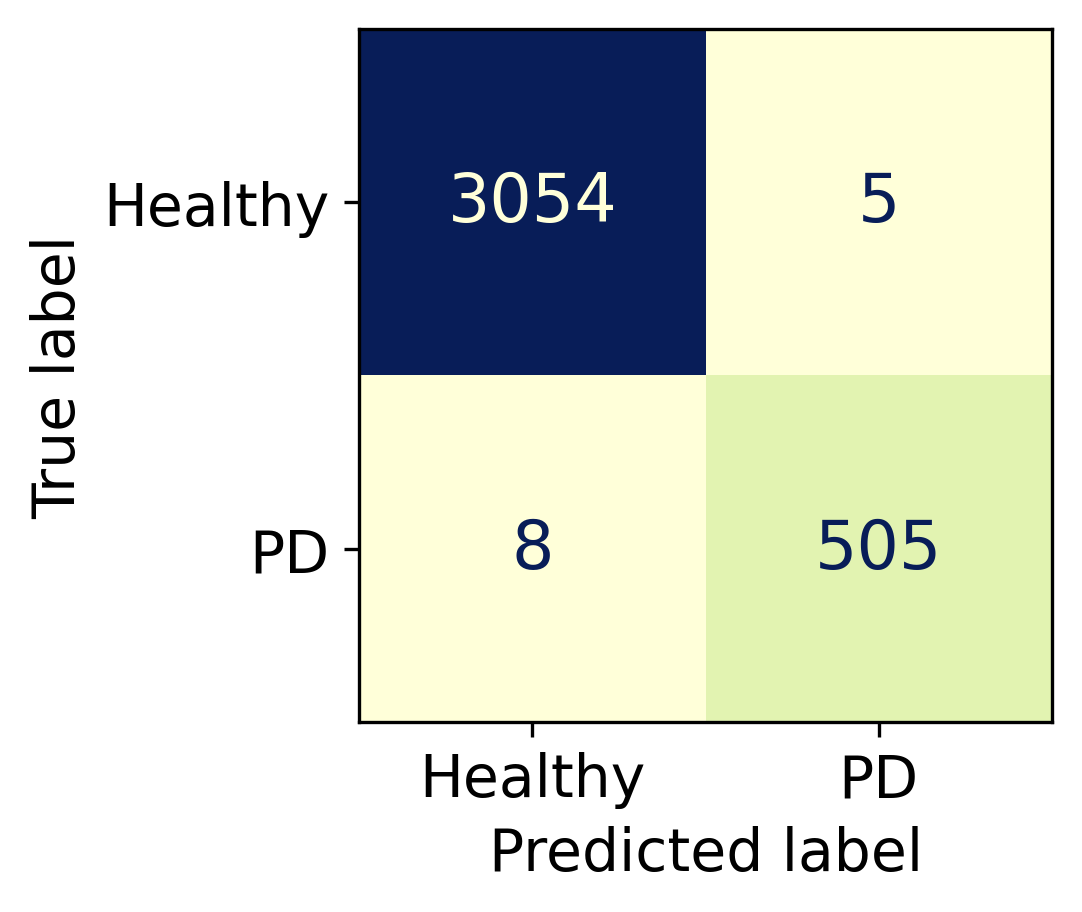

In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
correct = 0
for data, target in test_loader:
        # output = A(inputs) # Feed Network
        # print(output)
        # print(output.shape)

        # output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        # y_pred.extend(output) # Save Prediction

        # target = target.data.cpu().numpy()
        # target = (target[:, 1] > 0.5).astype("int32")
        # y_true.extend(target) # Save Trut

        # transfer the data on the chosen device
        data, target = data.to(device), target.to(device)
        target=target.float()

        # forward propagation on the data
        prediction = neural_net(data)

        # compute the number of correct predictions en sortie)
        _, pred_classes = torch.max(prediction, dim=1)
        _, target_classes = torch.max(target, dim=1)
        y_true.extend(target_classes)
        y_pred.extend(pred_classes)
        correct += int(pred_classes.eq(target_classes).sum().item())

# constant for classes
classes = ('Healthy','PD')

#print(type(target))

# Build confusion matrix
cf_matrix = confusion_matrix(y_pred, y_true)
cf_matrix2 = np.array([[cf_matrix[1,1],cf_matrix[0,1]],[cf_matrix[1,0],cf_matrix[0,0]]])
print(cf_matrix)
print(cf_matrix2)

cf_matrix = cf_matrix2

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

cmd = ConfusionMatrixDisplay(cf_matrix, display_labels=['Healthy','PD'])
cmd.plot(cmap = 'YlGnBu', colorbar = False)

#cmd.plot(cmap = 'YlGnBu', colorbar = False)

fig = cmd.ax_.get_figure()

fig.set_figwidth(3)
fig.set_figheight(3)
plt.rcParams["figure.dpi"] = 300
plt.rc('font', size=16)
# Set the axes title font size
plt.rc('axes', titlesize=14)
# Set the axes labels font size
plt.rc('axes', labelsize=14)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=14)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=14)
#plt.savefig(dpi = 300, fname = 'astro_LR.png')
#sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

####Create plots of the learning curves.

In [ ]:
!pip install matplotlib==3.1.3

In [ ]:
#Plot
x = list(range(len(train_losses)))
ax = plt.subplot(111)

# #Feb 5 new: set ticks, axis and spins black
# ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
# ax.spines['bottom'].set_color('black')

# ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
# ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue

# ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
# ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black

plt.plot(x, train_losses, 'b', label="Train")
plt.plot(x, val_losses, 'r', label="Validation")
plt.xlabel('epoch', size=16)
plt.ylabel('Cross-entropy loss', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

f = plt.figure()
# f.set_figwidth(4)
# f.set_figheight(4)

# leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
# leg.get_frame().set_alpha(0.99)

#Add a legend
pos = ax.get_position()
#ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
# ax.legend(loc='lower center', bbox_to_anchor=(1.33, 0.91), frameon = False, fontsize = 16)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), frameon = True, fontsize = 16)

plt.savefig("train_losses.png", transparent = True, bbox_inches='tight')

In [ ]:
x = list(range(len(train_accuracies)))
ax = plt.subplot(111)

# #Feb 5 new: set ticks, axis and spins black
# ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
# ax.spines['bottom'].set_color('black')

# ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
# ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue

# ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
# ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black

plt.plot(x, train_accuracies, 'b', label="Train")
plt.plot(x, val_accuracies, 'r', label="Validation")
plt.xlabel('epoch', size = 16)
plt.ylabel('Accuracy', size = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

f = plt.figure()

# Add a legend
pos = ax.get_position()
# ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
# ax.legend(loc='center right', bbox_to_anchor=(1.33, 0.91), facecolor = 'white')

plt.rcParams["figure.dpi"] = 500
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), frameon = True, fontsize = 16)
plt.savefig("train_accuracies.png", transparent = True, bbox_inches='tight')

In [ ]:
x = list(range(len(train_accuracies)))
ax = plt.subplot(111)

#Feb 5 new: set ticks, axis and spins black
ax.spines['left'].set_color('black')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('black')

ax.xaxis.label.set_color('black')        #setting up X-axis label color to yellow
ax.yaxis.label.set_color('black')          #setting up Y-axis label color to blue

ax.tick_params(axis='x', colors='black')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='black')  #setting up Y-axis tick color to black

plt.plot(x, train_accuracies, 'b', label="Train")
plt.plot(x, val_accuracies, 'r', label="Validation")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=False, fancybox=False)
leg.get_frame().set_alpha(0.99)

# Add a legend
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
ax.legend(loc='center right', bbox_to_anchor=(1.33, 0.91), facecolor = 'white')

plt.rcParams["figure.dpi"] = 500

plt.rc('font', size=14)
# Set the axes title font size
plt.rc('axes', titlesize=12)
# Set the axes labels font size
plt.rc('axes', labelsize=12)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)
# Set the axes title font size
plt.rc('axes', titlesize=12)
# Set the axes labels font size
plt.rc('axes', labelsize=12)

plt.savefig("train_accuracies.png", transparent = True, bbox_inches='tight')